In [ ]:
!pip install shortuuid

In [19]:
import copy
import csv
import cv2
import glob
import os
import re
import shutil
import time
from collections import Counter
from datetime import timedelta
import shortuuid

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(precision=4)

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)


def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C1"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data-c1/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data-c1/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)
TRAIN_SPLIT_PATCHES_DATA_DIR   = "data-c1/train/patches"
TRAIN_SPLIT_PATCHES_ANN_FILE   = ann_file(TRAIN_SPLIT_PATCHES_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data-c1/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)
TRAIN_ALL_PATCHES_DATA_DIR     = "data-c1/train-all/patches"
TRAIN_ALL_PATCHES_ANN_FILE     = ann_file(TRAIN_ALL_PATCHES_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data-c1/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)
VAL_SPLIT_PATCHES_DATA_DIR = "data-c1/val/patches"
VAL_SPLIT_PATCHES_ANN_FILE = ann_file(VAL_SPLIT_PATCHES_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"

TEST_PATCHES_DATA_DIR = "data/test/"
#TEST_PATCHES_DATA_DIR = "data/test/patches"


## GPU configuration
If you have a GPU, enable experimental memory growth.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Split data
Generate random, stratified 80/20 split for training and validation sets

In [3]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [4]:
DESIRED_CLASS_SAMPLE_COUNT = 400
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 5
PATCH_COLUMNS = 5


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                #transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
                
                transforms.RandomRotation((90,90), expand=True),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip()
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [5]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Generate Patches

In [18]:
# SPLIT train patches
if os.path.exists(TRAIN_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT training data patches...")
    generate_patch_files(TRAIN_SPLIT_AUGMENTED_DATA_DIR, TRAIN_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT training patch data annotations...")
    image_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, index=False)
    
# SPLIT val patches
if os.path.exists(VAL_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(VAL_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT validation data patches...")
    generate_patch_files(VAL_SPLIT_DATA_DIR, VAL_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT validation patch data annotations...")
    image_df = pd.read_csv(VAL_SPLIT_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(VAL_SPLIT_PATCHES_ANN_FILE, index=False)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(TEST_DATA_DIR, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
# ALL train patches
if os.path.exists(TRAIN_ALL_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_ALL_PATCHES_DATA_DIR))
else:
    print("Generating ALL train data patches...")
    generate_patch_files(TRAIN_ALL_AUGMENTED_DATA_DIR, TRAIN_ALL_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating ALL training patch data annotations...")
    image_df = pd.read_csv(TRAIN_ALL_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_ALL_PATCHES_ANN_FILE, index=False)

print("Done.")

data-c1/train/patches exists. Skipping.
data-c1/val/patches exists. Skipping.
Generating test data patches...
data-c1/train-all/patches exists. Skipping.
Done.


In [7]:
class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_generator,
                 val_generator=None,
                 test_generator=None,
                 train_patch_ann_df=None,
                 val_patch_ann_df=None,
                 train_whole_image_ann_df=None,
                 val_whole_image_ann_df=None):
        self.class_weights = class_weights
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.test_generator = test_generator
        self.train_patch_ann_df = train_patch_ann_df
        self.val_patch_ann_df = val_patch_ann_df
        self.train_whole_image_ann_df = train_whole_image_ann_df
        self.val_whole_image_ann_df = val_whole_image_ann_df

In [8]:
def train_val_split_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_whole_image_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
        
    data_gen_args = dict(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True
    )
    train_datagen = ImageDataGenerator(**data_gen_args)
    val_datagen = ImageDataGenerator(**data_gen_args)


    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    print("Defining validation data generator...")
    val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
        
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=32,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
    
    return SoybeanDataGroup(class_weights, 
                            train_generator, 
                            val_generator, 
                            test_generator,
                            train_ann_df,
                            val_ann_df,
                            train_whole_image_ann_df, 
                            val_whole_image_ann_df)


In [9]:
def all_train_data_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})    
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
        
    data_gen_args = dict(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True,
    )
    train_datagen = ImageDataGenerator(**data_gen_args)


    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=ann_df,
            directory=TRAIN_DATA_PATCHES_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
   
        
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_DATA_PATCHES_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )  
    
    
    return SoybeanDataGroup(class_weights, 
                            train_generator, 
                            None, 
                            test_generator,
                            ann_df,
                            None,
                            train_whole_image_ann_df)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [10]:
def get_model(n1, n2, dropout):
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg_model.trainable = False

    model = tf.keras.models.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(n2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [11]:
def compute_class_weights(df, y_col):
    """
    Returns a dictionary mapping class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy().flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return {label: weight for label, weight in enumerate(weights)}
    

In [12]:
# group = train_val_split_group()


# train_whole_image_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
# val_whole_image_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

# print("Reading annotations...")
# train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
# val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})


# print("Computing class weights...")
# class_weights = compute_class_weights(train_ann_df, 'annotation')


# batch_size = 32

# print("Defining data generators...")
# data_gen_args = dict(
#     rescale=1./255,
#     featurewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_center=True,
#     samplewise_std_normalization=True,
#     #rotation_range=10,
#     #width_shift_range=0.2,
#     #height_shift_range=0.2,
#     #horizontal_flip=True
# )
# train_datagen = ImageDataGenerator(**data_gen_args)
# val_datagen = ImageDataGenerator(**data_gen_args)


# print("Defining train data generator...")
# train_generator = train_datagen.flow_from_dataframe(
#         dataframe=train_patches_df,
#         directory=train_dir_patches,
#         x_col="file_name",
#         y_col="annotation",
#         batch_size=batch_size,
#         class_mode='sparse',
#         target_size=(224,224)
# )
# print("Defining validation data generator...")
# val_generator = val_datagen.flow_from_dataframe(
#         dataframe=val_patches_df,
#         directory=train_dir_patches,
#         x_col="file_name",
#         y_col="annotation",
#         batch_size=batch_size,
#         class_mode='sparse',
#         target_size=(224,224)
# )

# # Model
# print("Defining model...")
# model = get_model()
# model.summary()

# #model.load_weights('model_vgg16.h5')

# print('Fitting model...')

# history = model.fit(train_generator, 
#                     steps_per_epoch=int(train_patches_df.shape[0] / batch_size), 
#                     epochs=60, 
#                     validation_data=val_generator, 
#                     class_weight=class_weights, 
#                     verbose=1, 
#                     validation_steps=int(val_patches_df.shape[0] / batch_size))

# print('Evaluating model...')
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')

# test_result = model.evaluate(val_generator, verbose=1)
# print('Test result:', test_result)

# # Save the model weights
# model.save_weights('model_vgg16_c2_tf.h5')

## Train models

In [29]:
BATCH_SIZE = 32


def train(run_id, model, group, num_epochs):     
    model.summary()

    print('Fitting model...')
    
    print('group.train_patch_ann_df.shape[0]=', group.train_patch_ann_df.shape[0])
    print('int(group.train_patch_ann_df.shape[0] / BATCH_SIZE)', int(group.train_patch_ann_df.shape[0] / BATCH_SIZE))

    history = model.fit(group.train_generator, 
                        steps_per_epoch=int(group.train_patch_ann_df.shape[0] / BATCH_SIZE), 
                        epochs=num_epochs,  
                        class_weight=group.class_weights,
                        validation_data=group.val_generator,
                        validation_steps=int(group.val_patch_ann_df.shape[0] / BATCH_SIZE),
                        verbose=1)

    
    return model, history


def get_all_labels(loader):
    all_labels = torch.tensor([], dtype=torch.long)
    for batch in loader:
        _, _, labels = batch
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_labels


def get_all_whole_image_filenames(loader):
    return loader.dataset.whole_image_data['file_name'].to_numpy()
    

def get_all_whole_image_labels(loader):
    return loader.dataset.whole_image_data['annotation'].to_numpy(dtype=int)


def get_all_whole_image_predictions(patch_preds):
    patch_pred_groups = np.split(patch_preds, int(len(patch_preds)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_preds = np.array(list(map(lambda x: stats.mode(x).mode[0], patch_pred_groups)))
    return image_preds


def plot_metrics(run_id, output_dir, model, history, train_dataloader, val_dataloader=None):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    
    
#     # Training confusion matrix
#     train_patch_labels = get_all_labels(train_generator)
#     train_patch_predictions = predict(model, train_generator)
    
#     print("Training Confusion Matrix of Patches")
#     print("-" * 30)
#     print_confusion_matrix(train_patch_labels, train_patch_predictions)
    
#     # Generate prediction label results file
#     write_patch_predictions(run_id, 'train', output_dir, train_generator, train_patch_predictions)
    
    
#     print("Training Confusion Matrix of Whole Images")
#     print("-" * 30)
#     train_whole_image_filenames = get_all_whole_image_filenames(train_generator)
#     train_whole_image_labels = get_all_whole_image_labels(train_generator)
#     train_whole_image_predictions = get_all_whole_image_predictions(train_patch_predictions)
#     print_confusion_matrix(train_whole_image_labels, train_whole_image_predictions)
    
#     write_whole_image_predictions(run_id, 'train', output_dir, 
#                                   train_whole_image_filenames, 
#                                   train_whole_image_labels, 
#                                   train_whole_image_predictions)
    
#     # Validation confusion matrix
#     if val_generator is not None:
#         val_patch_labels = get_all_labels(val_dataloader)
#         val_patch_predictions = predict(model, val_dataloader)
        
#         print("Validation Confusion Matrix of Patches")
#         print("-" * 30)
#         print_confusion_matrix(val_patch_labels, val_patch_predictions)
        
#         print("Validation Confusion Matrix of Whole Images")
#         print("-" * 30)
#         val_whole_image_filenames = get_all_whole_image_filenames(val_dataloader)
#         val_whole_image_labels = get_all_whole_image_labels(val_dataloader)
#         val_whole_image_predictions = get_all_whole_image_predictions(val_patch_predictions)
#         print_confusion_matrix(val_whole_image_labels, val_whole_image_predictions)
        
#         # Generate prediction label results file
#         write_patch_predictions(run_id, 'val', output_dir, val_dataloader, val_patch_predictions)
        
#         write_whole_image_predictions(run_id, 'val', output_dir, 
#                                   val_whole_image_filenames, 
#                                   val_whole_image_labels, 
#                                   val_whole_image_predictions)
    


def train_and_test(run_id, model, group, num_epochs, output_dir):    
    model_trained, history = train(run_id, model, group, num_epochs)
    
    # Save weights
    model_trained.save_weights(os.path.join(output_dir, "{}_weights.h5".format(run_id)))
    
    # Plot history metrics
    plot_metrics(run_id, output_dir, model_trained, history, group.train_generator, group.val_generator)
    
    # Classify test data
    return predict(model_trained, group.test_generator)


def predict(model, data_generator):
    y_hat_logits = model.predict(data_generator)
    y_hat = tf.map_fn(lambda x: tf.argmax(x), y_hat_logits, dtype=tf.int64)
    return y_hat



def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    confusion_matrix = np.zeros((5, 5))
    labels = [0, 1, 2, 3, 4]
    for i in range(len(labels)):
        for j in range(len(labels)):
            ground_truth = y==labels[i]
            prediction = y_hat==labels[j]
            confusion_matrix[i, j] = sum(np.bitwise_and(ground_truth, prediction))
    df = pd.DataFrame(confusion_matrix, dtype=int)
    display(df)


def write_patch_predictions(run_id, phase, output_dir, dataloader, patch_predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    i = 0
    for file_names, _, labels in dataloader:
        for j in range(BATCH_SIZE):
            if len(file_names) > j:
                df = df.append({'file_name': file_names[j], 
                                'annotation': labels[j].item(), 
                                'prediction': patch_predictions[i]}, ignore_index=True)
                i += 1

    df.to_csv(os.path.join(output_dir, "{}_{}_patch_predictions.csv".format(run_id, phase)), index=False)
    

def write_whole_image_predictions(run_id, phase, output_dir, filenames, labels, predictions):
    print('filenames:', len(filenames))
    print('labels:', len(labels))
    print('predictions:', len(predictions))
    
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    for i in range(len(filenames)):
        df = df.append({'file_name': filenames[i], 
                        'annotation': labels[i], 
                        'prediction': predictions[i]}, ignore_index=True)
        
    df.to_csv(os.path.join(output_dir, "{}_{}_whole_image_predictions.csv".format(run_id, phase)), index=False)
        

## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [14]:
def run_trial(name, model, class_weights=None, num_epochs=40):
    run_id = shortuuid.uuid()
    
    # output directory
    output_dir = os.path.join("output_tf", run_id)
    os.makedirs(output_dir)
    print("Output generated to:", output_dir)
    
    
    y_hat_test = train_and_test(run_id, model, train_val_split_group(class_weights), num_epochs, output_dir)
    predictions_file = os.path.join(output_dir, "{}_predict_c2_{}_test.csv".format(run_id, name))
    print('predictions file:', predictions_file)
    predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
    return y_hat_test

In [23]:
run_id = "AJr5eR3kg6UEQAUdUnVjJd"
name = "h1"
group = train_val_split_group(None)
output_dir = "output_tf/AJr5eR3kg6UEQAUdUnVjJd"
y_hat_test = predict(model, group.test_generator)
predictions_file = os.path.join(output_dir, "{}_predict_c2_{}_test.csv".format(run_id, name))
print('predictions file:', predictions_file)
predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
y_hat_test

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
predictions file: output_tf/AJr5eR3kg6UEQAUdUnVjJd/AJr5eR3kg6UEQAUdUnVjJd_predict_c2_h1_test.csv
0: 68
1: 56
2: 16
3: 5
4: 55
Finished generating predictions to output_tf/AJr5eR3kg6UEQAUdUnVjJd/AJr5eR3kg6UEQAUdUnVjJd_predict_c2_h1_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([2, 2, 2, ..., 0, 0, 0])>

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output_tf/9NWUwLF34eEFEqzMVD4xgp
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_____________________________________________________________

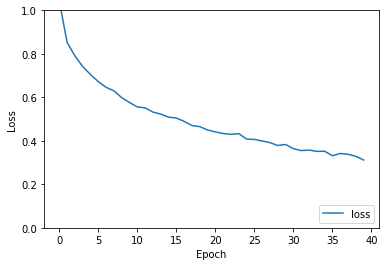

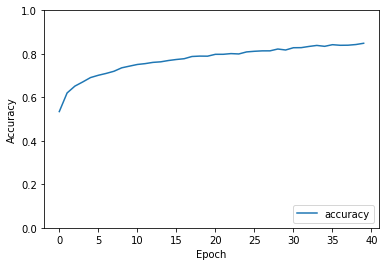

predictions file: output_tf/9NWUwLF34eEFEqzMVD4xgp/9NWUwLF34eEFEqzMVD4xgp_predict_c2_h1_test.csv
0: 82
1: 53
2: 3
3: 20
4: 42
Finished generating predictions to output_tf/9NWUwLF34eEFEqzMVD4xgp/9NWUwLF34eEFEqzMVD4xgp_predict_c2_h1_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([1, 2, 0, ..., 0, 0, 0])>

In [25]:
model = get_model(1024, 128, 0.5)
run_trial("h1", model, num_epochs=40)

Output generated to: output_tf/cnHpCaqKkvLghmHpjkYZ6d
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_____________________________________________________________

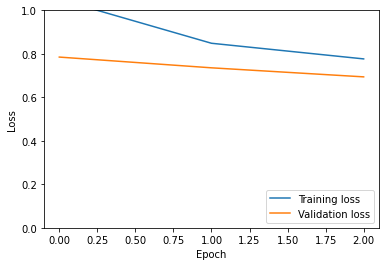

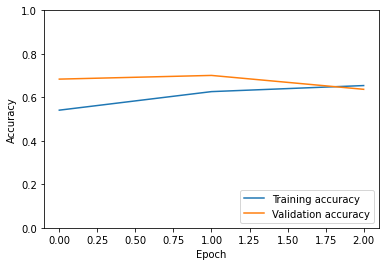

predictions file: output_tf/cnHpCaqKkvLghmHpjkYZ6d/cnHpCaqKkvLghmHpjkYZ6d_predict_c2_h1_test.csv
0: 64
1: 72
2: 6
3: 3
4: 55
Finished generating predictions to output_tf/cnHpCaqKkvLghmHpjkYZ6d/cnHpCaqKkvLghmHpjkYZ6d_predict_c2_h1_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([0, 2, 0, ..., 0, 0, 0])>

In [30]:
model = get_model(1024, 128, 0.5)
run_trial("h1", model, num_epochs=3)

#### H2: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [ ]:
model = get_model(2048, 256, 0.5)
run_trial("h2", model)

#### H3: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [ ]:
model = get_model(512, 64, 0.5)
run_trial("h3", model)

#### H4: Best from above, dropout 0.25

* DNN Structure: 
* Dropout: 0.25
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [ ]:
model = get_model(2048, 256, model = get_model(1024, 128, 0.1)
run_trial("h5", model)0.25)
run_trial("h4", model)

#### H5: Best from above, dropout 0.1

* DNN Structure: 
* Dropout: 0.1
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output_tf/PTvaUJZWZ3Ao8MabmR43wS
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_____________________________________________________________

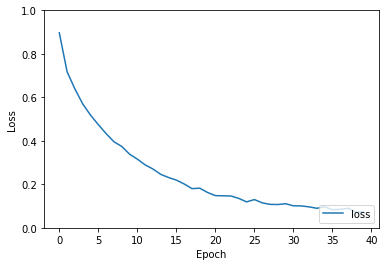

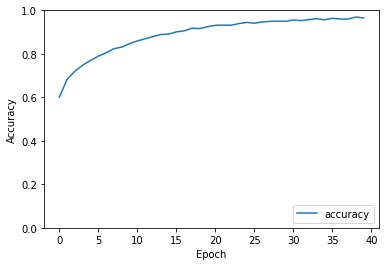

predictions file: output_tf/PTvaUJZWZ3Ao8MabmR43wS/PTvaUJZWZ3Ao8MabmR43wS_predict_c2_h5_test.csv
0: 80
1: 59
2: 1
3: 28
4: 32
Finished generating predictions to output_tf/PTvaUJZWZ3Ao8MabmR43wS/PTvaUJZWZ3Ao8MabmR43wS_predict_c2_h5_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([1, 0, 0, ..., 0, 0, 0])>

In [24]:
model = get_model(1024, 128, 0.1)
run_trial("h5", model)

#### H6: Best from above, skewed class weights

* DNN Structure: 
* Dropout: 0.5
* Class weights: [1,1,5,5,1]
* Batch normalization: no


In [ ]:
model = get_model(n1, n2, 0.5)
run_trial("h6", model, class_weights=[1., 1., 2., 2., 1.])

#### H7: Best from above, batch normalization

* DNN Structure: 
* Dropout: 0.5
* Class weights: 
* Batch normalization: yes


In [ ]:
model = get_model(n1, n2, 0.5, batch_normalization=True).to(device)
run_trial("h7", model)

#### Summary: Best hyperparameters

In [ ]:
optimal_n1 = 1024
optimal_n2 = 128
optimal_d = 0.1


## Train with all C2 data and optimal hyperparameters

In [ ]:
model = get_model(optimal_n1, optimal_n2, optimal_d)
# model.load_state_dict(torch.load('cnn_pytorch_c2.pt'))
y_hat_test = train_and_test(model, group_3(), num_epochs=40)
predictions_file = "predict_c2_{}.csv".format(shortuuid.uuid())
print('predictions file:', predictions_file)
predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)